# House Prices Prediction using TensorFlow Decision Forests

Need to datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).
[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

%matplotlib inline

ModuleNotFoundError: No module named 'tensorflow'

In [8]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [9]:
currentDirectory = os.getcwd()
parentDirectory = os.path.abspath(os.path.join(currentDirectory, os.pardir))
dataset_df = pd.read_csv(os.path.join(
   parentDirectory,
   "input/house-prices-advanced-regression-techniques/train.csv"))
test_df = pd.read_csv(os.path.join(
   parentDirectory,
   "input/house-prices-advanced-regression-techniques/test.csv"))

In [10]:
dataset_df = dataset_df.drop('Id', axis=1)

- MSSubClass:
- MSZoning:
- LotFrontage:
- LotArea:
- Street:
- Alley:
- LotShape:
- LandContour:
- Utilities:
- LotConfig:
- LandSlope:
- Neighborhood:
- Condition1:
- Condition2:
- BldgType:
- HouseStyle:
- OverallQual:
- OverallCond:
- YearBuilt:
- YearRemodAdd:
- RoofStyle:
- RoofMatl:
- Exterior1st:
- Exterior2nd:
- MasVnrType:
- MasVnrArea:
- ExterQual:
- ExterCond:
- Foundation:
- BsmtQual:
- BsmtCond:
- BsmtExposure:
- BsmtFinType1:
- BsmtFinSF1:
- BsmtFinType2:
- BsmtFinSF2:
- BsmtUnfSF:
- TotalBsmtSF:
- Heating:
- HeatingQC:
- CentralAir:
- Electrical:
- 1stFlrSF:
- 2ndFlrSF:
- LowQualFinSF:
- GrLivArea:
- BsmtFullBath:
- BsmtHalfBath:
- FullBath:
- HalfBath:
- BedroomAbvGr:
- KitchenAbvGr:
- KitchenQual:
- TotRmsAbvGrd:
- Functional:
- Fireplaces:
- FireplaceQu:
- GarageType:
- GarageYrBlt:
- GarageFinish:
- GarageFinish:
- GarageCars:
- GarageArea:
- GarageQual:
- GarageCond:
- PavedDrive:
- WoodDeckSF:
- OpenPorchSF:
- EnclosedPorch:
- 3SsnPorch:
- ScreenPorch:
- PoolArea:
- PoolQC:
- Fence:
- MiscFeature:
- MiscVal:
- MoSold:
- YrSold:
- SaleType:
- SaleCondition:
- SalePrice:

KeyboardInterrupt: 

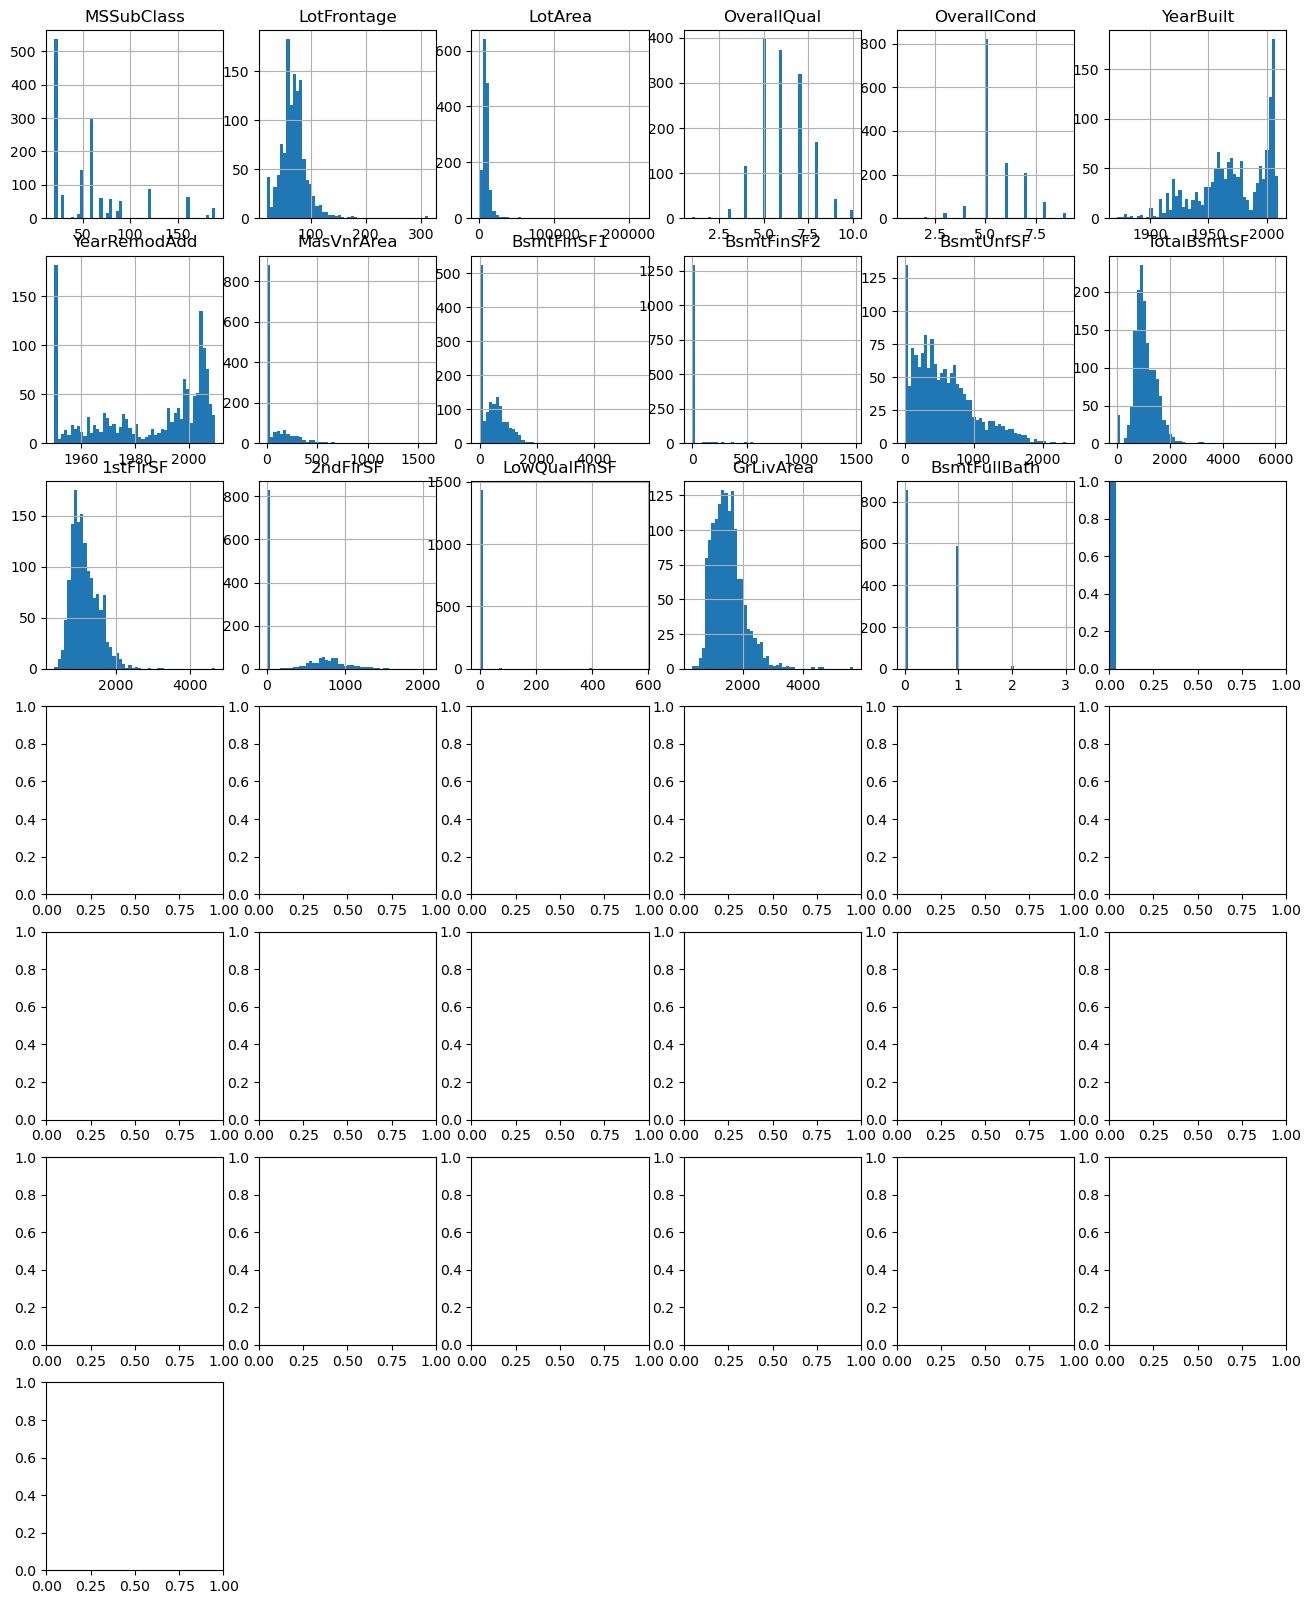

In [11]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [ ]:
def split_dataset(dataset, test_ratio=0.30):
    """
    Used to split dataset into training and validating datasets
    """
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]
train_ds_pd, valid_ds_pd = split_dataset(dataset_df)

In [ ]:
# By default the Random Forest Model is configured to train classification tasks.
# Since this is a regression problem, we will specify the type of the task (`tfdf.keras.Task.REGRESSION`)
# as a parameter here.
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [ ]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION) #specify the task type as tfdf.keras.Task.REGRESSION.
rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

In [ ]:
rf.fit(x=train_ds)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

In [ ]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [ ]:
inspector = rf.make_inspector()
inspector.evaluation() #We can also see some general stats on the OOB dataset:

In [ ]:
#Now, let us run an evaluation using the validation dataset.
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

In [ ]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
    print("\t", importance)

In [ ]:
inspector.variable_importances()["NUM_AS_ROOT"]

In [ ]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [ ]:
ids = test_df.pop('Id')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_df,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

In [ ]:
output

In [ ]:
output.to_csv("submission.csv", index=False)

In [ ]:
#sample_submission_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
#sample_submission_df['SalePrice'] = rf.predict(test_ds)
#sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
#sample_submission_df.head()